In [1]:
# Import required Packages

import dask
from dask.distributed import Client, progress

#import gcsfs

import xarray as xr

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

In [2]:
client = Client()  # Set up local cluster on your machine
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 8
Total threads: 40,Total memory: 503.29 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:45377,Workers: 0
Dashboard: http://127.0.0.1:8787/status,Total threads: 0
Started: Just now,Total memory: 0 B
Comm: tcp://127.0.0.1:42587,Total threads: 5
Dashboard: http://127.0.0.1:41843/status,Memory: 62.91 GiB
Nanny: tcp://127.0.0.1:42189,


# Specifying Choices

In [3]:
# City latitude and longitude and convert to degrees east for longitude
city_lat = 42.87
city_lon = (-109.86)+360

# 5 degree X 5 degree box around city
lat_st = city_lat-5
lat_ed = city_lat+5
lon_st = city_lon-5
lon_ed = city_lon+5

# 40 degree X 40 degree box around city
lat_st_big = city_lat-40
lat_ed_big = city_lat+40
lon_st_big = city_lon-40
lon_ed_big = city_lon+40

# Specify start and end date
start_date = '2014-01-01 00:00'
end_date = '2024-12-31 23:59'

# Gathering Data

In [4]:
# Open Analysis-Ready Cloud Optimized ERA5 files from Google
ds = xr.open_zarr(
    'gs://gcp-public-data-arco-era5/ar/full_37-1h-0p25deg-chunk-1.zarr-v3',
    chunks=None,
    storage_options=dict(token='anon'),
)
ds = ds.sel(time=slice(ds.attrs['valid_time_start'], ds.attrs['valid_time_stop']))

ds

<xarray.Dataset> Size: 2PB
Dimensions:                                                          (
                                                                      time: 748008,
                                                                      latitude: 721,
                                                                      longitude: 1440,
                                                                      level: 37)
Coordinates:
  * latitude                                                         (latitude) float32 3kB ...
  * level                                                            (level) int64 296B ...
  * longitude                                                        (longitude) float32 6kB ...
  * time                                                             (time) datetime64[ns] 6MB ...
Data variables: (12/273)
    100m_u_component_of_wind                                         (time, latitude, longitude) float32 3TB ...
    100m_v_component_of_wind                                         (time, latitude, longitude) float32 3TB ...
    10m_u_component_of_neutral_wind                                  (time, latitude, longitude) float32 3TB ...
    10m_u_component_of_wind                                          (time, latitude, longitude) float32 3TB ...
    10m_v_component_of_neutral_wind                                  (time, latitude, longitude) float32 3TB ...
    10m_v_component_of_wind                                          (time, latitude, longitude) float32 3TB ...
    ...                                                               ...
    wave_spectral_directional_width_for_swell                        (time, latitude, longitude) float32 3TB ...
    wave_spectral_directional_width_for_wind_waves                   (time, latitude, longitude) float32 3TB ...
    wave_spectral_kurtosis                                           (time, latitude, longitude) float32 3TB ...
    wave_spectral_peakedness                                         (time, latitude, longitude) float32 3TB ...
    wave_spectral_skewness                                           (time, latitude, longitude) float32 3TB ...
    zero_degree_level                                                (time, latitude, longitude) float32 3TB ...
Attributes:
    last_updated:           2025-09-23 01:49:41.225776+00:00
    valid_time_start:       1940-01-01
    valid_time_stop:        2025-04-30
    valid_time_stop_era5t:  2025-09-17

In [5]:
# Read in ERA5 total precipitaion for each month from 1981 to 2020 at each grid point [m]
all_monthly_precip_1981_2020 = xr.open_dataset('ERA-5_total_precipitation_monthly-1981-2020.nc')
all_monthly_precip_1981_2020

<xarray.Dataset> Size: 2GB
Dimensions:     (valid_time: 372, latitude: 721, longitude: 1440)
Coordinates:
    number      int64 8B ...
  * valid_time  (valid_time) datetime64[ns] 3kB 1990-01-01T06:00:00 ... 2020-...
  * latitude    (latitude) float64 6kB 90.0 89.75 89.5 ... -89.5 -89.75 -90.0
  * longitude   (longitude) float64 12kB 0.0 0.25 0.5 0.75 ... 359.2 359.5 359.8
    expver      (valid_time) <U4 6kB ...
Data variables:
    tp          (valid_time, latitude, longitude) float32 2GB ...
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2025-09-22T22:03 GRIB to CDM+CF via cfgrib-0.9.1...

In [6]:
# Selecting the data for a variable
tot_precip_data = ds.total_precipitation
tot_precip_data

<xarray.DataArray 'total_precipitation' (time: 748008, latitude: 721,
                                         longitude: 1440)> Size: 3TB
[776611825920 values with dtype=float32]
Coordinates:
  * latitude   (latitude) float32 3kB 90.0 89.75 89.5 ... -89.5 -89.75 -90.0
  * longitude  (longitude) float32 6kB 0.0 0.25 0.5 0.75 ... 359.2 359.5 359.8
  * time       (time) datetime64[ns] 6MB 1940-01-01 ... 2025-04-30T23:00:00
Attributes:
    long_name:   Total precipitation
    short_name:  tp
    units:       m

In [7]:
# Make dataframe of data in the box for date range
tot_precip_data_box = tot_precip_data.sel(latitude=slice(lat_ed,lat_st), longitude=slice(lon_st, lon_ed),
                                          time=slice(start_date,end_date))

# Makes dataframe of data at point nearest to city for date range
tot_precip_data_city = tot_precip_data.sel(latitude=city_lat, longitude=city_lon, 
                                           method='nearest').sel(time=slice(start_date,end_date))

# 1) Time series of daily precipitation at City

In [ ]:
# Calculating daily precipitation from hourly precipitation at City
daily_precip_city = tot_precip_data_city.resample(time="D").sum()

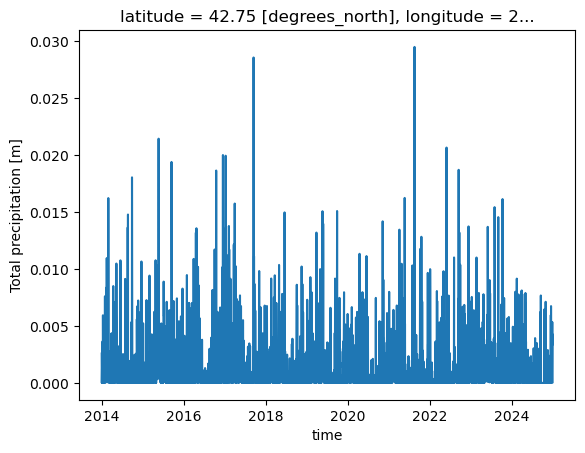

In [7]:
daily_precip_city.plot()

In [ ]:
# Calculating daily precipitation from hourly precipitation at each point in 5X5 box
daily_precip_data_box = tot_precip_data_box.resample(time="D").sum()
daily_precip_data_box

In [ ]:
# Saving daily preciptation data over box
daily_precip_data_box.to_netcdf("daily_precip_lat"+str(lat_st)+"_"+str(lat_ed)+"_Lon"+str(lon_st)+"_"+str(lon_ed)+
                            "time"+start_date[0:9]+"-"+end_date[0:9]+".nc")

# 2) 95% of daily precipitation and CDF

In [8]:
daily_precip_data_box = xr.open_dataset("daily_precip_lat"+str(lat_st)+"_"+str(lat_ed)+"_Lon"+str(lon_st)+"_"+str(lon_ed)+
                             "time"+start_date[0:9]+"-"+end_date[0:9]+".nc")
daily_precip_data_box

<xarray.Dataset> Size: 26MB
Dimensions:              (time: 4018, latitude: 40, longitude: 40)
Coordinates:
  * latitude             (latitude) float32 160B 47.75 47.5 47.25 ... 38.25 38.0
  * longitude            (longitude) float32 160B 245.2 245.5 ... 254.8 255.0
  * time                 (time) datetime64[ns] 32kB 2014-01-01 ... 2024-12-31
Data variables:
    total_precipitation  (time, latitude, longitude) float32 26MB ...

In [9]:
# Convert from m to mm
daily_precip_box_mm = daily_precip_data_box*1000
daily_precip_box_mm

<xarray.Dataset> Size: 26MB
Dimensions:              (latitude: 40, longitude: 40, time: 4018)
Coordinates:
  * latitude             (latitude) float32 160B 47.75 47.5 47.25 ... 38.25 38.0
  * longitude            (longitude) float32 160B 245.2 245.5 ... 254.8 255.0
  * time                 (time) datetime64[ns] 32kB 2014-01-01 ... 2024-12-31
Data variables:
    total_precipitation  (time, latitude, longitude) float32 26MB 0.2382 ... 0.0

In [13]:
area_mean_daily_tot_precip = daily_precip_box_mm.mean(dim=['latitude','longitude'])
area_mean_daily_tot_precip

<xarray.Dataset> Size: 48kB
Dimensions:              (time: 4018)
Coordinates:
  * time                 (time) datetime64[ns] 32kB 2014-01-01 ... 2024-12-31
Data variables:
    total_precipitation  (time) float32 16kB 2.536 0.06953 ... 3.899 0.5885

In [14]:
# val_95th = np.quantile(area_daily_tot_precip, .95)
val_95th = np.quantile(area_mean_daily_tot_precip.total_precipitation, .95)
val_95th

np.float32(4.654321)

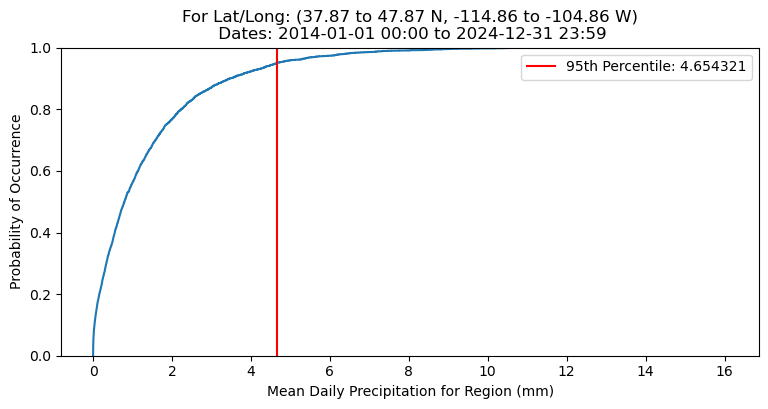

In [15]:
plt.figure(figsize=(9, 4))
plt.ecdf(area_mean_daily_tot_precip.total_precipitation)
plt.axvline(x=val_95th, c='r', label='95th Percentile: '+str(val_95th))
plt.xlabel('Mean Daily Precipitation for Region (mm)')
plt.ylabel('Probability of Occurrence')
plt.title('For Lat/Long: ('+str(lat_st)+' to '+str(lat_ed)+' N, '
          +str(np.round(lon_st-360,2))+' to '+str(np.round(lon_ed-360,2))+' W)\n Dates: '
          +start_date+' to '+end_date)
plt.legend()

# 3a) Map of composite mean precipitation on the 95% days for continental US

In [16]:
dates_95th = area_mean_daily_tot_precip.time[np.where(area_mean_daily_tot_precip.total_precipitation >= val_95th)[0]].values
dates_95th

array(['2014-01-30T00:00:00.000000000', '2014-02-09T00:00:00.000000000',
       '2014-03-01T00:00:00.000000000', '2014-03-11T00:00:00.000000000',
       '2014-03-30T00:00:00.000000000', '2014-04-13T00:00:00.000000000',
       '2014-04-26T00:00:00.000000000', '2014-04-27T00:00:00.000000000',
       '2014-05-07T00:00:00.000000000', '2014-05-11T00:00:00.000000000',
       '2014-06-17T00:00:00.000000000', '2014-06-27T00:00:00.000000000',
       '2014-08-05T00:00:00.000000000', '2014-08-22T00:00:00.000000000',
       '2014-08-23T00:00:00.000000000', '2014-08-24T00:00:00.000000000',
       '2014-09-27T00:00:00.000000000', '2014-09-28T00:00:00.000000000',
       '2014-09-29T00:00:00.000000000', '2014-11-10T00:00:00.000000000',
       '2014-12-21T00:00:00.000000000', '2014-12-25T00:00:00.000000000',
       '2015-04-15T00:00:00.000000000', '2015-04-25T00:00:00.000000000',
       '2015-04-26T00:00:00.000000000', '2015-05-07T00:00:00.000000000',
       '2015-05-09T00:00:00.000000000', '2015-05-15

In [17]:
# For all grid points in continential US...
# choosing the dates where the mean daily precipitation in our 5X5 box exceeded the 95th percentile.
# Then, take the average precipitation at each grid point over those dates.
# Finally, conver to mm
us_mean_precip_95th = tot_precip_data.sel(latitude=slice(49.38,24.52), longitude=slice(-124.85+360,-66.95+360),
                                        time=dates_95th).mean(dim=['time'])*1000
us_mean_precip_95th

<xarray.DataArray 'total_precipitation' (latitude: 99, longitude: 232)> Size: 92kB
array([[0.1836239 , 0.16927353, 0.15743965, ..., 0.1332022 , 0.12407926,
        0.1148059 ],
       [0.26464725, 0.27256614, 0.2381557 , ..., 0.13445741, 0.12614755,
        0.11757462],
       [0.23238787, 0.23172158, 0.24177365, ..., 0.13170817, 0.12564765,
        0.11902076],
       ...,
       [0.01361396, 0.0148008 , 0.01312323, ..., 0.14974025, 0.196209  ,
        0.23352408],
       [0.01950588, 0.02252041, 0.02321202, ..., 0.17181261, 0.23604055,
        0.26705614],
       [0.02305531, 0.0251367 , 0.02614033, ..., 0.19917059, 0.23952127,
        0.23026824]], shape=(99, 232), dtype=float32)
Coordinates:
  * latitude   (latitude) float32 396B 49.25 49.0 48.75 ... 25.25 25.0 24.75
  * longitude  (longitude) float32 928B 235.2 235.5 235.8 ... 292.5 292.8 293.0

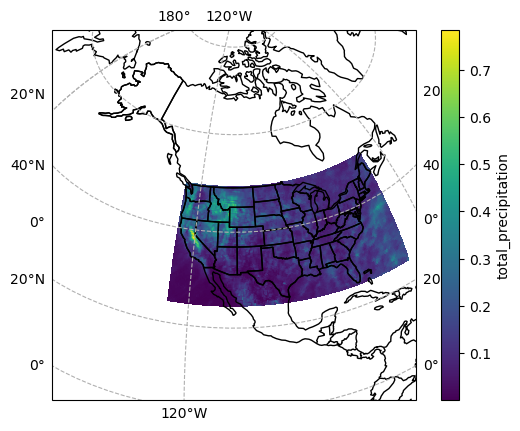

In [18]:
fig, axis = plt.subplots(1, 1, subplot_kw=dict(
    projection=ccrs.Orthographic(city_lon, city_lat))
    )
axis.set_extent([lon_st_big, lon_ed_big, lat_st_big, lat_ed_big], crs=ccrs.PlateCarree())
us_mean_precip_95th.plot(ax=axis, transform=ccrs.PlateCarree())

axis.gridlines(draw_labels=True,linestyle='--')
axis.add_feature(cfeature.STATES)
axis.add_feature(cfeature.BORDERS)
axis.add_feature(cfeature.COASTLINE)

# 3b) Map of anomaly precipitation from 1981-2010 mean

In [19]:
# Take total precipitaion for each month from 1981 to 2020 at all ERA5 grid points [m].
# Select over continential US.
# Calculate the average preciptitation from 1981 to 2020.
# Convert to mm
us_mean_precip_81_10 = all_monthly_precip_1981_2020.sel(
    latitude=slice(49.38,24.52), longitude=slice(-124.85+360,-66.95+360)).tp.mean(dim=['valid_time']
  )*1000
us_mean_precip_81_10

<xarray.DataArray 'tp' (latitude: 99, longitude: 232)> Size: 92kB
array([[5.4968686 , 4.666923  , 4.7142043 , ..., 3.391294  , 3.150458  ,
        3.073023  ],
       [6.9318533 , 6.2607665 , 5.347552  , ..., 3.244187  , 3.3346736 ,
        3.3781478 ],
       [7.5485373 , 7.055306  , 6.2406573 , ..., 3.1189277 , 3.353765  ,
        3.5058324 ],
       ...,
       [0.37316608, 0.36978722, 0.36091188, ..., 2.8963985 , 2.906671  ,
        2.8780122 ],
       [0.3895452 , 0.37589636, 0.36826184, ..., 2.8329127 , 2.8889358 ,
        2.8654914 ],
       [0.40656775, 0.39173198, 0.3783421 , ..., 2.7969344 , 2.8477023 ,
        2.830467  ]], shape=(99, 232), dtype=float32)
Coordinates:
    number     int64 8B ...
  * latitude   (latitude) float64 792B 49.25 49.0 48.75 ... 25.25 25.0 24.75
  * longitude  (longitude) float64 2kB 235.2 235.5 235.8 ... 292.5 292.8 293.0

In [20]:
# Calculate the anomoly of the mean precipitation over the US 
# on days with >= 95% precipitation in 5X5 box from the mean precipitation over the US from 1981 to 2020
anom = us_mean_precip_95th - (us_mean_precip_81_10)
anom

<xarray.DataArray (latitude: 99, longitude: 232)> Size: 92kB
array([[-5.313245  , -4.4976497 , -4.5567646 , ..., -3.258092  ,
        -3.0263789 , -2.9582171 ],
       [-6.667206  , -5.9882    , -5.109396  , ..., -3.1097298 ,
        -3.2085261 , -3.2605731 ],
       [-7.316149  , -6.8235846 , -5.9988837 , ..., -2.9872196 ,
        -3.2281175 , -3.3868117 ],
       ...,
       [-0.35955212, -0.35498643, -0.34778863, ..., -2.7466583 ,
        -2.710462  , -2.644488  ],
       [-0.3700393 , -0.35337597, -0.34504983, ..., -2.6611001 ,
        -2.6528952 , -2.5984352 ],
       [-0.38351244, -0.36659527, -0.35220176, ..., -2.5977638 ,
        -2.608181  , -2.6001987 ]], shape=(99, 232), dtype=float32)
Coordinates:
  * latitude   (latitude) float32 396B 49.25 49.0 48.75 ... 25.25 25.0 24.75
  * longitude  (longitude) float32 928B 235.2 235.5 235.8 ... 292.5 292.8 293.0
    number     int64 8B ...

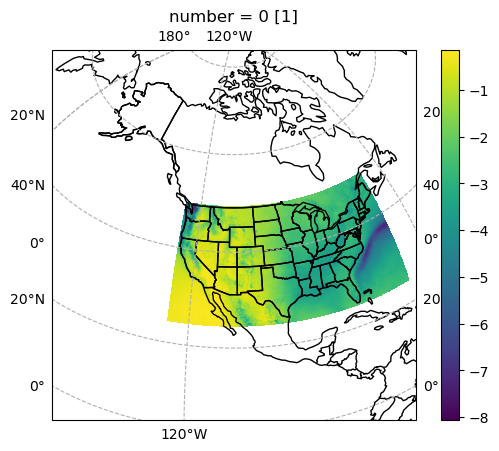

In [21]:
fig, axis = plt.subplots(1, 1, subplot_kw=dict(
    projection=ccrs.Orthographic(city_lon, city_lat))
    )
axis.set_extent([lon_st_big, lon_ed_big, lat_st_big, lat_ed_big], crs=ccrs.PlateCarree())
anom.plot(ax=axis, transform=ccrs.PlateCarree())
axis.gridlines(draw_labels=True,linestyle='--')
axis.add_feature(cfeature.STATES)
axis.add_feature(cfeature.BORDERS)
axis.add_feature(cfeature.COASTLINE)

In [22]:
client.close()